# Differential training of a GeodesyNet
In this notebook we show how to train a neural density field to represent the difference between a known, homogeneously filled, asteroid and a heterogeneous ground truth.

With respect to a *normal* training (see Starter Notebook) the differences in the code are minimal. Conceptually, we are now taking advantage of a ground truth 3D model of the asteroid surface.

We suggest to run this notebook in the same conda environment described in the Starter Notebook.

In [1]:
# core stuff
import gravann
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

Will use device  cpu


/home/dario/Develop/geodesynets/gravann/_utils.py:80: UserWarning: Error enabling CUDA. cuda.is_available() returned False. CPU will be used.
  warnings.warn(


# Loading and visualizing the ground truth asteroid
Here we load the ground truth model (mascon) used to generate synthetic acceleration readings. Note that the ground truth is heterogenous, that is its internal mass distribution is not uniform.

In [2]:
# We load the ground truth (a mascon model of some heterogenous body)
with open("mascons/Itokawa_nu.pk", "rb") as file:
    mascon_points, mascon_masses_nu, mascon_name = pk.load(file)
# We also load the homogenous version of the same body
with open("mascons/Itokawa.pk", "rb") as file:
    _, mascon_masses_u, _ = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses_nu = torch.tensor(mascon_masses_nu)
mascon_masses_u = torch.tensor(mascon_masses_u)


# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates
# are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of points: ", len(mascon_points))
print("Total mass (homogenous): ", sum(mascon_masses_u))
print("Total mass (heterogeneous): ", sum(mascon_masses_nu))


Name:  Itokawa non-uniform
Number of points:  41748
Total mass (uniform):  tensor(1.0000, dtype=torch.float64)
Total mass (non uniform):  tensor(1.0000, dtype=torch.float64)


<IPython.core.display.Javascript object>


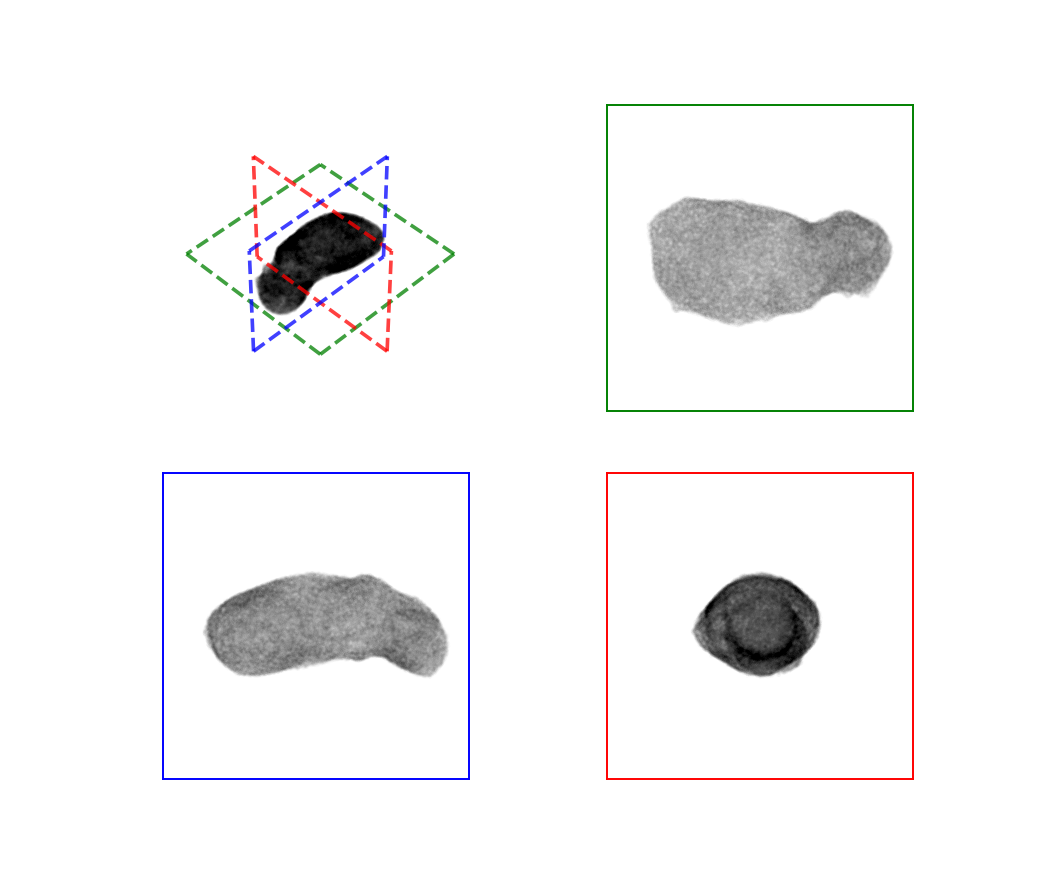

In [3]:
# Here we visualize the loaded ground truth. Darker areas,
# the head in the case of Itokawa, correspond to heavier densities.
gravann.plot_mascon(mascon_points, mascon_masses_nu)

# Representing an asteroid via a neural network


## 1 - Defining the network architecture
Here the only change w.r.t. a normal training is the activation function of the last layer
which needs to allow for negative numbers (to be able to remove mass from a homogeneous reference distribution) and is thus an hyperbolic tangent.

In [4]:
# Encoding: direct encoding (i.e. feeding the network directly with the Cartesian coordinates in the unit hypercube)
# was found to work well in most cases. But more options are implemented in the module.
encoding = gravann.direct_encoding()

# The model is here a SIREN network (FFNN with sin non linearities and a final hyperbolic tangent to predict the density)
model = gravann.init_network(encoding, n_neurons=100, model_type="default", activation =  nn.Tanh())

# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []
# .. and we init a loss trend indicators
weighted_average = deque([], maxlen=20)

In [ ]:
# IF YOU NOW WANT TO LOAD THE ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail
#model.load_state_dict(torch.load("FILENAME"))

## Visualizing an asteroid represented by the network
The network output is the density in the unit cube. It is, essentially, a three dimensional function we plot via rejection sampling. 

In [ ]:
gravann.plot_model_rejection(model, encoding, views_2d=False, N=2500, progressbar=True, c=100)
plt.title("Believe it or not I am an asteroid")

# Training The ANN to match the ground truth potential

Let it run up to when its < 1e-3 to actually see something that resembles the original asteroid. When stuck increase the number of monte carlo samples or play around the learning rate.

In [ ]:
# EXPERIMENTAL SETUP ------------------------------------------------------------------------------------
# Here we set some hyperparameters
N_mc_points = 20000
batch_size = 100

# Here we set the loss
#loss_fn = gravann.mse_loss
loss_fn = gravann.normalized_loss

# Here we set the choosen Integration method
#mc_method = gravann.ACC_ld
mc_method = gravann.ACC_trap

# Here we set the method to sample the target points
targets_point_sampler = gravann.get_target_point_sampler(batch_size, 
                                                         limit_shape_to_asteroid="3dmeshes/Hollow_raw_lp.pk", 
                                                         method="spherical", 
                                                         bounds=[0,1])
# Here we set the optimizer
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.8, patience=200, min_lr=1e-8, verbose=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9,nesterov=True)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0005, max_lr=0.5, step_size_up=250, mode="exp_range", gamma = .997)

In [ ]:
# This cell can be stopped and started again without loosing memory of the training nor its indicators
torch.cuda.empty_cache()
# The main training loop
for i in range(5000):
    # Each ten epochs we resample the target points
    if (i % 10 == 0):
        target_points = targets_point_sampler()
    labels_u = gravann.ACC_L(target_points, mascon_points, mascon_masses_u)
    labels_nu = gravann.ACC_L(target_points, mascon_points, mascon_masses_nu)
    labels = labels_nu - labels_u
    
    # Compute the loss (use N=3000 to start with, then, eventually, beef it up to 200000)
    predicted = mc_method(target_points, model, encoding, N=N_mc_points)
    
    
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    if loss_fn == gravann.contrastive_loss:
       loss = loss_fn(predicted, labels)
    else:
       loss = loss_fn(predicted.view(-1), labels.view(-1))
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    n_inferences.append((N_mc_points*batch_size) // 1000)
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

In [ ]:
# Plot the loss history
plt.figure()
abscissa = np.cumsum(n_inferences)
plt.semilogy(abscissa, loss_log)
plt.semilogy(abscissa, weighted_average_log)
plt.xlabel("Thousands of model evaluations")
plt.ylabel("Loss")
plt.legend(["Loss","Weighted Average Loss"])

In [ ]:
# Rejection plot overlayed with the mascon
gravann.plot_model_vs_mascon_contours(model, encoding, mascon_points, mascon_masses_nu,c=c, progressbar = True, N=2500, heatmap=True)

In [ ]:
# Generating a mesh out of the model
gravann.plot_model_mesh(model,encoding,rho_threshold=c.cpu().detach().numpy()*1e-2) 

In [ ]:
# Compute c 
#target_points = targets_point_sampler()
#labels = gravann.ACC_L(target_points, mascon_points, mascon_masses)
#predicted = mc_method(target_points, model, encoding, N=N_mc_points)
#c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)

In [ ]:
# Computes the Validation table
gravann.validation(model, encoding, mascon_points, mascon_masses_nu, use_acc=True, asteroid_pk_path="3dmeshes/Bennu_lp.pk", N=5000, N_integration=500000, batch_size=32, progressbar=True)

In [ ]:
# Compute the acceleration plot
gravann.plot_model_mascon_acceleration("3dmeshes/Bennu.pk", model, encoding, mascon_points, mascon_masses, plane="XY", c=c, N=5000, logscale=False)

#### Saving the model

In [ ]:
# Uncomment to save to models/cluster_xxxx
#torch.save(model.state_dict(), "models/siren_acc_bennu.mdl")